In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
version_list = list(range(40))
metas = [pd.read_csv(f'./logs/mimic_dBCQ/version_{ver}/meta_tags.csv').set_index('key') for ver in version_list]
tau_list = [meta.loc['threshold'][0] for meta in metas]
dfs = [pd.read_csv(f'./logs/mimic_dBCQ/version_{ver}/metrics.csv').iloc[:100] for ver in version_list]

In [5]:
colors = {
    '0.0': 'tab:red',
    '0.01': 'tab:orange',
    '0.05': 'tab:olive',
    '0.1': 'tab:green',
    '0.3': 'tab:cyan',
    '0.5': 'tab:blue',
    '0.75': 'tab:purple',
    '0.9999': 'tab:pink',
}

In [6]:
from operator import itemgetter, attrgetter
import numpy as np

def pareto2d(data):
    sorted_data = sorted(data, key=itemgetter(0, 1), reverse=True)
    pareto_idx = list()
    pareto_idx.append(0)
    cutt_off = sorted_data[0][1]
    for i in range(1, len(sorted_data)):
        if sorted_data[i][1] > cutt_off:
            pareto_idx.append(i)
            cutt_off = sorted_data[i][1]
    return pareto_idx

## Trade-offs

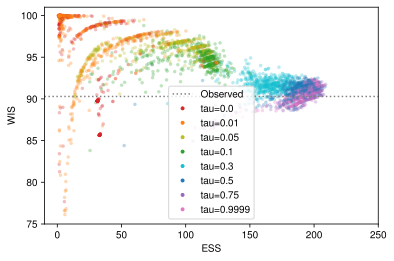

In [22]:
for tau, df in zip(tau_list, dfs):
    plt.scatter(df['val_ess'], df['val_wis'], s=50, marker='.', c=colors[tau], linewidths=0, alpha=0.3)
plt.xlabel('ESS')
plt.ylabel('WIS')
plt.xlim(-10,250)
plt.ylim(75,101)
plt.axhline(90.2936, ls=':', c='grey', label='Observed')
for tau, c in colors.items():
    plt.plot(0, 0, '.', c=colors[tau], label=f'tau={tau}')
plt.legend()
plt.show()

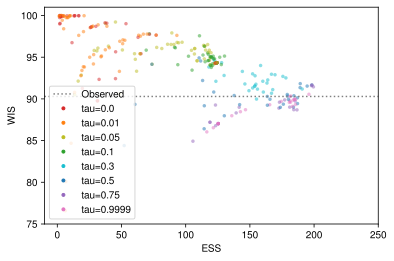

In [10]:
for tau, df in zip(tau_list, dfs):
    pareto_idx = pareto2d(df[['val_wis', 'val_ess']].values)
    plt.scatter(df.iloc[pareto_idx]['val_ess'], df.iloc[pareto_idx]['val_wis'], s=50, marker='.', c=colors[tau], linewidths=0, alpha=0.5)
plt.xlabel('ESS')
plt.ylabel('WIS')
plt.xlim(-10,250)
plt.ylim(75,101)
plt.axhline(90.2936, ls=':', c='grey', label='Observed')
for tau, c in colors.items():
    plt.plot(0, 0, '.', c=colors[tau], label=f'tau={tau}')
plt.legend()
plt.show()

## Model selection

In [35]:
ESS_cutoff = 100

In [36]:
results = []
for ver, df in enumerate(dfs):
    df_tmp = df[df['val_ess'] >= ESS_cutoff]['val_wis']
    if len(df_tmp) > 0:
        results.append((ver, df.loc[df_tmp.idxmax()]))

In [37]:
val_scores = [row['val_wis'] for ver, row in results]
val_ess = [row['val_ess'] for ver, row in results]
hparams = [(ver, row['iteration']) for ver, row in results]

In [38]:
best_idx = np.argmax(val_scores)
best_ver, best_iter = hparams[best_idx]
val_scores[best_idx], val_ess[best_idx], hparams[best_idx]

(98.1409683227539, 100.19548034667967, (6, 3200.0))

In [15]:
from types import SimpleNamespace
import torch
from torch.utils.data import DataLoader
from data import EpisodicBuffer, SASRBuffer, remap_rewards
from model import BCQ

In [39]:
bcq_model = BCQ.load_from_checkpoint(checkpoint_path=f'./logs/mimic_dBCQ/version_{best_ver}/checkpoints/step={int(best_iter-1)}.ckpt', map_location=None)
bcq_model.eval()

BCQ(
  (Q): BCQ_Net(
    (q): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=25, bias=True)
    )
    (πb): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=25, bias=True)
    )
  )
  (Q_target): BCQ_Net(
    (q): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=25, bias=True)
    )
    (πb): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (

In [24]:
state_dim = 64
num_actions = 25
horizon = 20

In [41]:
test_episodes = EpisodicBuffer(state_dim, num_actions, horizon)
test_episodes.load('../data/episodes+encoded_state+knn_pibs/test_data.pt')
test_episodes.reward = remap_rewards(test_episodes.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

tmp_test_episodes_loader = DataLoader(test_episodes, batch_size=len(test_episodes), shuffle=False)
test_batch = next(iter(tmp_test_episodes_loader))
test_wis, test_ess = bcq_model.offline_evaluation(test_batch, weighted=True, eps=0.01)
test_wis, test_ess

Episodic Buffer loaded with 2894 episides.


(94.14629332693481, 89.2499551773696)

In [42]:
from torch.utils.data import Dataset
class EpisodicBufferF(Dataset):
    def __init__(self, state_dim, num_actions, horizon, buffer_size=0):
        self.max_size = int(buffer_size)
        self.horizon = horizon
        self.state = torch.zeros((self.max_size, horizon, state_dim))
        self.action = torch.zeros((self.max_size, horizon, 1), dtype=torch.long)
        self.subaction = torch.zeros((self.max_size, horizon, 2), dtype=torch.long)
        self.subactionvec = torch.zeros((self.max_size, horizon, 10))
        self.reward = torch.zeros((self.max_size, horizon, 1))
        self.not_done = torch.zeros((self.max_size, horizon, 1))
        self.subpibs = torch.zeros((self.max_size, horizon, 10))
        self.estm_subpibs = torch.zeros((self.max_size, horizon, 10))
    
    def __len__(self):
        return len(self.state)
    
    def __getitem__(self, idx):
        return (
            self.state[idx],
            self.action[idx],
            self.subaction[idx],
            self.subactionvec[idx],
            self.reward[idx],
            self.not_done[idx],
            self.subpibs[idx],
            self.estm_subpibs[idx],
        )
    
    def load(self, filename):
        data = torch.load(filename)
        self.state = data['statevecs'][:, :-1, :]
        self.action = data['actions'][:, 1:].unsqueeze(-1)  # Need to offset by 1 so that we predict actions that have not yet occurred
        self.subaction = data['subactions'][:, 1:, :]  # Need to offset by 1 so that we predict actions that have not yet occurred
        self.subactionvec = data['subactionvecs'][:, 1:, :]  # Need to offset by 1 so that we predict actions that have not yet occurred
        self.reward = data['rewards'][:, 1:].unsqueeze(-1)  # Need to offset by 1
        self.not_done = data['notdones'][:, 1:].unsqueeze(-1)
        self.subpibs = data['subpibs'][:, :-1, :]
        self.estm_subpibs = data['estm_subpibs'][:, :-1, :]
        print(f"Episodic Buffer loaded with {len(self)} episides.")

In [43]:
def offline_evaluation_F(self, eval_buffer, weighted=True, eps=0.01):
    states, actions, subactions, subactionvecs, rewards, not_dones, subpibs, estm_subpibs = eval_buffer
    rewards = rewards[:, :, 0].cpu().numpy()
    n, horizon, _ = states.shape
    discounted_rewards = rewards * (self.eval_discount ** np.arange(horizon))

    ir = np.ones((n, horizon))
    for idx in range(n):
        lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

        # Predict Q-values and Imitation probabilities
        q, imt, _ = self.Q(states[idx])
        imt = imt.exp()
        imt = (imt / imt.max(1, keepdim=True).values > self.threshold).float()

        # Use large negative number to mask actions from argmax
        a_id = (imt * q + (1. - imt) * torch.finfo().min).argmax(axis=1).cpu().numpy()
        pie_soft = np.zeros((horizon, 25))
        estm_pibs = np.einsum('bi,bj->bji', estm_subpibs[idx][:,:5].cpu().numpy(), estm_subpibs[idx][:,5:].cpu().numpy()).reshape((-1, 25))
        pie_soft += eps * estm_pibs # Soften using training behavior policy
        pie_soft[range(horizon), a_id] += (1.0 - eps)

        # Compute importance sampling ratios
        a_obs = actions[idx, :, 0]
        ir[idx, :lng] = pie_soft[range(lng), a_obs[:lng].cpu().numpy()] / \
            (subpibs[idx, range(lng), a_obs[:lng] % 5].cpu().numpy() * subpibs[idx, range(lng), 5+a_obs[:lng] // 5].cpu().numpy())
        ir[idx, lng:] = 1  # Mask out the padded timesteps

    weights = np.clip(ir.cumprod(axis=1), 0, 1e3)
    if weighted:
        weights_norm = weights.sum(axis=0)
    else:
        weights_norm = weights.shape[0]
    weights /= weights_norm

    ess = (weights[:,-1].sum()) ** 2 / (((weights[:,-1]) ** 2).sum())
    estm = (weights[:,-1] * discounted_rewards.sum(axis=-1)).sum()

    return estm, ess

In [44]:
test_episodes_F = EpisodicBufferF(state_dim, num_actions, horizon)
test_episodes_F.load('../data/episodes+encoded_state+knn_pibs_factored/test_data.pt')
test_episodes_F.reward = remap_rewards(test_episodes_F.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

tmp_test_episodes_loader_F = DataLoader(test_episodes_F, batch_size=len(test_episodes_F), shuffle=False)
test_batch_F = next(iter(tmp_test_episodes_loader_F))
test_wis_F, test_ess_F = offline_evaluation_F(bcq_model, test_batch_F, weighted=True, eps=0.01)
test_wis_F, test_ess_F

Episodic Buffer loaded with 2894 episides.


/tmp/ipykernel_16875/3214053596.py:26: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (subpibs[idx, range(lng), a_obs[:lng] % 5].cpu().numpy() * subpibs[idx, range(lng), 5+a_obs[:lng] // 5].cpu().numpy())


(94.1021547501523, 102.72475837455637)